# Long term stability of Trappist-1
The Trappist-1 system (see https://en.wikipedia.org/wiki/TRAPPIST-1) long-term stability has been debated and studied in a series of high-visibility works. 

Here we show how to use heyoka to setup a parallel simulation of the long-term stability of the system starting from several initial conditions. 

Thread parallelism is possible as the heyoka Taylor integrator releases the python GIL.

In [1]:
#core
import heyoka as hey
import numpy as np
import pykep as pk

#plots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

#misc
from copy import deepcopy
from multiprocessing.pool import ThreadPool

## Here we define the data of the Trappist-1 system
In the code below, we define a number of physical properties of the Trappist-1 system. We will be using SI units throughout.

In [2]:
# Cavendish constant (kg m^3/s^2)
G = 6.67430E-11
# Sun_mass (kg)
SM = 1.989E30
# Earth mass (kg)
EM = 5.972E24
# This data comes from the paper (https://arxiv.org/pdf/1802.01377.pdf)
masses = np.array([0.089 * SM, 1.017 * EM, 1.156 * EM, 0.297 * EM, 0.772  * EM, 0.934 * EM, 1.148 * EM, 0.331 * EM])
masses_sigma_p = np.array([0.007 * SM, 0.154 * EM, 0.142 * EM, 0.039 * EM, 0.079 * EM, 0.80 * EM, 0.098 * EM, 0.056 * EM])
masses_sigma_m = np.array([0.007 * SM, 0.143 * EM, 0.131 * EM, 0.035 * EM, 0.075 * EM, 0.78 * EM, 0.095 * EM, 0.049 * EM])

inc = (90 - np.array([90., 89.65, 89.67, 89.75, 89.86, 89.68, 89.71, 89.80 ])) * pk.DEG2RAD
inc_sigma_p = np.array([0., 0.22, 0.17, 0.16, 0.10, 0.034, 0.025, 0.1]) * pk.DEG2RAD
inc_sigma_m = np.array([0., 0.27, 0.17, 0.16, 0.12, 0.034, 0.025, 0.05]) * pk.DEG2RAD

sma = np.array(      [0., 0.01154775, 0.01581512, 0.02228038 , 0.02928285, 0.03853361, 0.04687692, 0.06193488]) * pk.AU
sma_sigma = np.array([0., 5.7e-08, 1.5e-07, 4.4e-07, 3.4e-07, 4.8e-07, 3.2e-07, 8.0e-07]) * pk.AU

ecc = np.array([0, 0.00622, 0.00654, 0.00837, 0.00510, 0.01007, 0.00208, 0.00567])
ecc_sigma = np.array([0., 0.00304, 0.00188, 0.00093, 0.00058, 0.00068, 0.00058, 0.00121])

## Some auxiliary functions
Here we define a number of helper functions that will visualize as well as generate plausible Trappist-1 configurations.

In [3]:
# Plots the trappist system
def plot_trappist(state, mu, axes = None):
    letter = ["s", "a", "b", "c", "d", "e", "f", "g", "h"]
    colors = ["y", "C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    if axes is None:
        fig = plt.figure()
        axes = fig.add_subplot(111, projection='3d', aspect='auto')
    for i in range(1,8):
        el = pk.ic2par(state[i*6:3+i*6], state[3+i*6:6+i*6], mu)
        pla = pk.planet.keplerian(pk.epoch(0), el, mu, 1., 1., 1. , "Trappist-1"+letter[i])
        pk.orbit_plots.plot_planet(pla, axes=axes, color=colors[i])
    plt.axis('off')
    plt.tight_layout()
    axes.view_init(elev=90., azim=0.)
    axes.scatter(0,0,0,s=40,c='y')
    return axes

# Generates N plausible trappist systems
def trappist_generator(N, masses, masses_sigma_m, masses_sigma_p, sma, sma_sigma, ecc, ecc_sigma, inc, inc_sigma_m, inc_sigma_p):
    assert(len(masses) == 8)
    assert(len(masses_sigma_m) == 8)
    assert(len(masses_sigma_p) == 8)
    assert(len(sma) == 8)    
    assert(len(sma_sigma) == 8)    
    assert(len(ecc) == 8)
    assert(len(ecc_sigma) == 8)
    assert(len(inc) == 8)
    assert(len(inc_sigma_m) == 8)
    assert(len(inc_sigma_p) == 8)

    # First we generate the masses
    retval_masses = []
    for i in range(N):
        retval_masses.append(masses - masses_sigma_m + (masses_sigma_p - masses_sigma_m) * np.random.random(8))
    
    # Then the IC
    retval_ic = []
    for i in range(N):
        ic = [0.,0.,0.,0.,0.,0.]
        # Randomly sampling w, W, e and M
        w = np.random.random(8)*2*np.pi
        W = np.random.random(8)*2*np.pi
        E = np.random.random(8)*2*np.pi
        e = ecc + ecc_sigma * (np.random.random(8)*2-1)

        # Normal distributions for the others
        a = sma + sma_sigma * (np.random.random(8)*2-1)
        incl = inc - inc_sigma_m + (inc_sigma_p - inc_sigma_m) * np.random.random(8)

        MU_TRAPPIST = G * retval_masses[i][0]
        for j in range(1,8):
            r,v = pk.par2ic([a[j], e[j], incl[j], W[j], w[j], E[j]], MU_TRAPPIST)
            ic = ic + list(r) + list(v)
        ic = np.array(ic)
        #Corrects for COM
        for j in range(6):
            ic[j::6] = ic[j::6] - sum(ic[j::6] * retval_masses[i])/sum(retval_masses[i])

        retval_ic.append(ic)
    return retval_masses, retval_ic

## Multiprocessing script
This is the main part of the script. The scripts output is recorded in files as to make sure, in long simulations, to not lose intermediate data. 

In this particular notebook the simulation is only 500 years long and takes a few seconds. Changing the setup (and waiting longer) it is possible to simulate Myrs.

In [4]:
# Number of parallel process
nproc = 4
# Number of instances of the problem (i.e. ic to try)
ninst = 4
# Final integration time in Myr
final_time_Myr = 500 / 1e6
# Log frequency in years
log_frequency = 100
# Total number of log lines
N = int(final_time_Myr*1e6/log_frequency)
print("Number of final files generated: {:d}".format(N+1))
# We generate the various trappist systems
m, ic = trappist_generator(ninst, masses, masses_sigma_m, inc_sigma_p, sma, sma_sigma, ecc, ecc_sigma, inc, inc_sigma_m, inc_sigma_p)


Number of final files generated: 6


In [5]:
# This will simulate, monitor and log the i-th initial condition
def runner(i):
    # Generates the EOMs
    ode_sys = hey.make_nbody_sys(8, Gconst = G, masses = m[i])
    # Generates the Taylor integrator
    ta = hey.taylor_adaptive(ode_sys, ic[i], high_accuracy=True, tol=1e-18, compact_mode=True)
    dt = log_frequency * 365.25 * pk.DAY2SEC
    
    def data_saver(j, state):           
            np.save('trappist1_{}_{}.npy'.format(i,j), state)
            
    try:
        data_saver(0, ta.state)
        for j in range(1, N+1):
            oc, _, _, nsteps = ta.propagate_for(dt)
            data_saver(j, ta.state)
            if oc != hey.taylor_outcome.time_limit:
                break
    except BaseException as e:
        print("Exception caught in thread. The full error message:\n{}".format(str(e)), flush=True)
        

In [6]:
with ThreadPool(processes=nproc) as pool:
    pool.map(runner, range(ninst))

## Processing the simulation output


In [7]:
# This load the i-th simulation up to N * log_frequency years (if the files exist)
def load_sim(i, N):
    ret = []
    for j in range(N):
        try:
            tmp = np.load('trappist1_{}_{}.npy'.format(i,j))
            ret.append(tmp)
        except FileNotFoundError:
            pass
    return np.array(ret)

<IPython.core.display.Javascript object>


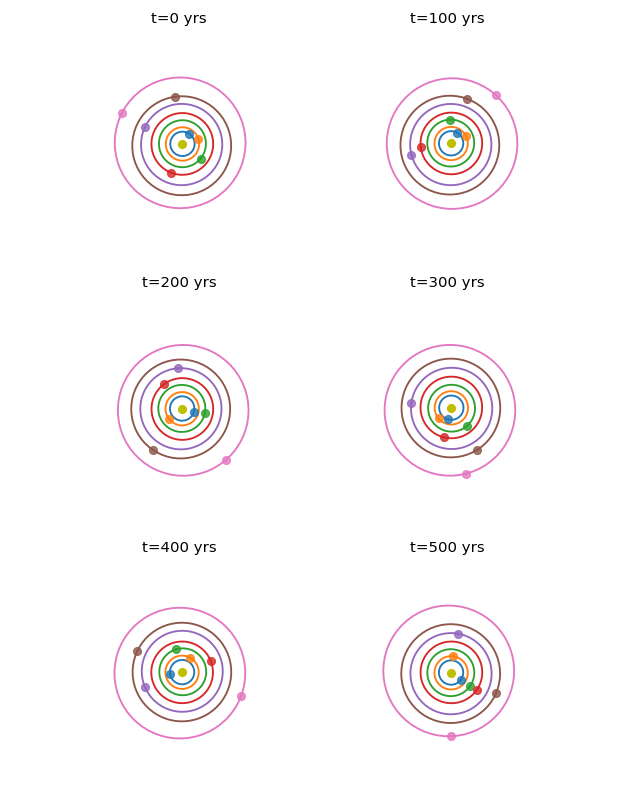

In [8]:
# Plots the system at 6 different epochs (bins of log_frequency years)
epochs = [0,1,2,3,4,5]
sim_id = 0
states = load_sim(sim_id,N+1)
mu = G*m[sim_id][0]

fig = plt.figure(figsize=(7,9))
for i in range(6):
    n = 320 + i + 1
    ax = fig.add_subplot(n, projection='3d', aspect='auto')
    ax = plot_trappist(states[epochs[i]], mu, axes = ax)
    ax.title.set_text('t='+str(log_frequency * epochs[i])+" yrs")